<a href="https://colab.research.google.com/github/quickgrid/CodeLab/blob/master/pytorch/Pytorch_UTKFace_AutoEncoder_with_Dataset_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### References

https://www.kaggle.com/ljlbarbosa/convolution-autoencoder-pytorch

https://discuss.pytorch.org/t/how-to-load-images-without-using-imagefolder/59999/2

https://discuss.pytorch.org/t/using-imagefolder-without-subfolders-labels/67439

In [1]:
!pip install torchsummary

In [2]:
!pip install gdown

In [3]:
!gdown https://drive.google.com/u/0/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /content/UTKFace.tar.gz
107MB [00:00, 117MB/s] 


In [4]:
import tarfile

fname = '/content/UTKFace.tar.gz'
tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()

In [5]:
import os

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
#from tqdm import tqdm
from tqdm.auto import tqdm

In [6]:
torch.manual_seed(17)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_channel_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=latent_channel_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.act1 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act1(x)
        x = self.pool1(x)
        return x

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_channel_dim):
        super(Decoder, self).__init__()
        self.t_conv1 = nn.ConvTranspose2d(in_channels=latent_channel_dim, out_channels=8, kernel_size=(2, 2), stride=(2, 2))
        self.t_conv2 = nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=(2, 2), stride=(2, 2))
        self.act1 = nn.ReLU()
        self.act2 = nn.Sigmoid()

    def forward(self, x):
        x = self.t_conv1(x)
        x = self.act1(x)
        x = self.t_conv2(x)
        x = self.act2(x)
        return x

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_channel_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(latent_channel_dim=latent_channel_dim)
        self.decoder = Decoder(latent_channel_dim=latent_channel_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
class UTKFaceDataset(Dataset):
    """Dataset for UTKFace."""

    def __init__(self, dir, transform):
        self.dir = dir
        self.transform = transform
        self.images = os.listdir(dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.dir, self.images[idx])
        image = Image.open(image_path)
        return self.transform(image)

In [11]:
latent_channel_dim = 4
n_epochs = 2
num_workers = 0
batch_size = 64

transform = transforms.ToTensor()
utkface_dataset = UTKFaceDataset('/content/UTKFace', transform=transform)
train_loader = torch.utils.data.DataLoader(utkface_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

model = AutoEncoder(latent_channel_dim).to(device)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
save_path = '/content/'

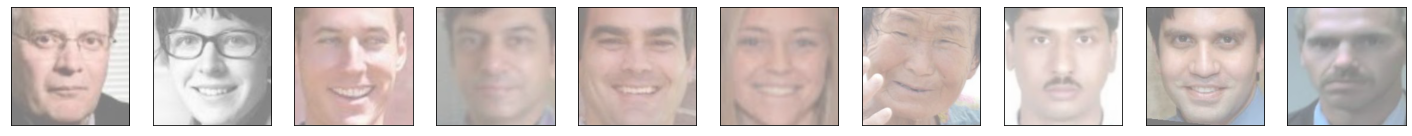

In [36]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image


dataiter = iter(train_loader)
images = dataiter.next()
images = images.numpy()


fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(1, 10 / 1, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()


Epoch: 0 	Training Loss: 35.264001


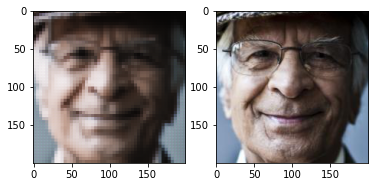


Epoch: 1 	Training Loss: 35.195417


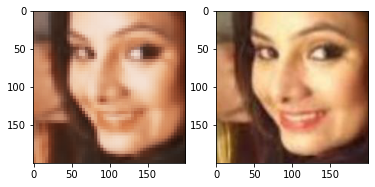

In [26]:
for epoch in range(n_epochs):
    train_loss = 0.0

    chosen_output = None
    chosen_image = None

    for idx, data in enumerate(tqdm(train_loader)):
        images = data
        images = images.to(device)

        # Zero out previous grads, forward pass, calculate loss, backpropagate, optimize
        optimizer.zero_grad()
        outputs = model(images)

        chosen_output = outputs[0]
        chosen_image = images[0]

        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
    ))

    if epoch % 1 == 0:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(np.transpose(chosen_output.detach().cpu().numpy(), (1, 2, 0)))
        ax[1].imshow(np.transpose(chosen_image.detach().cpu().numpy(), (1, 2, 0)))
        plt.show()

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, save_path + 'utkface' + str(epoch) + '.pth')

In [27]:
from torchsummary import summary
summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 200, 200]             224
              ReLU-2          [-1, 8, 200, 200]               0
         MaxPool2d-3          [-1, 8, 100, 100]               0
            Conv2d-4          [-1, 4, 100, 100]             292
              ReLU-5          [-1, 4, 100, 100]               0
         MaxPool2d-6            [-1, 4, 50, 50]               0
           Encoder-7            [-1, 4, 50, 50]               0
   ConvTranspose2d-8          [-1, 8, 100, 100]             136
              ReLU-9          [-1, 8, 100, 100]               0
  ConvTranspose2d-10          [-1, 3, 200, 200]              99
          Sigmoid-11          [-1, 3, 200, 200]               0
          Decoder-12          [-1, 3, 200, 200]               0
Total params: 751
Trainable params: 751
Non-trainable params: 0
---------------------------------------

In [28]:
checkpoint = torch.load(save_path + 'utkface' + str(n_epochs - 1) + '.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

torch.Size([3, 200, 200])


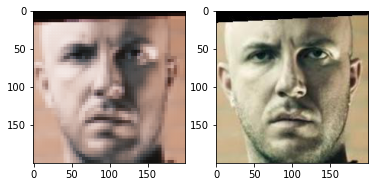

AutoEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (act1): ReLU()
  )
  (decoder): Decoder(
    (t_conv1): ConvTranspose2d(4, 8, kernel_size=(2, 2), stride=(2, 2))
    (t_conv2): ConvTranspose2d(8, 3, kernel_size=(2, 2), stride=(2, 2))
    (act1): ReLU()
    (act2): Sigmoid()
  )
)

In [35]:
img = utkface_dataset.__getitem__(41)
print(img.shape)

model.eval()

with torch.no_grad():
    img = img.to(device)
    out_data = model(torch.unsqueeze(img, 0)).to(device)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(np.transpose(out_data.squeeze().cpu().numpy(), (1, 2, 0)))
    ax[1].imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
    plt.show()

model.train()